# Project 4:. Advanced lane detection

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1. Camera calibration
The calibration implies computing the parameters to correct the camera lens distortion. First, multiple images of a well know, plane image, typically a chessboard-like image, are taken from multiple angles. This images allow the distortion correction algorithm to detect the correct parameters for distortion correction.

In [1]:
# Load calibration images. Show some examples (4 is ok)
# Save mtx and dist
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

rows = 6
cols = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((rows*cols,3), np.float32)
objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (cols,rows), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (cols,rows), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

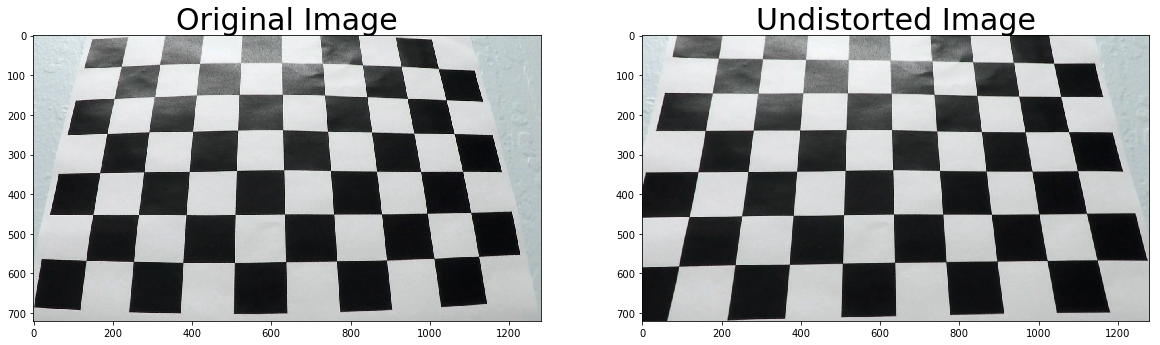

In [2]:
# Save calibration parameters

import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/calibration.p", "wb" ) )
print("Saved camera calibration parameters in: camera_cal/calibration.p" )

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## 2. Unwarp Image
Generally, camera sensors are positioned perpendicular to the road in autonomous vehicle setups. However, it is more useful to have a **bird eye** view, as if the camera were located over the road, with its sensor parallel to it. Unwarping the image implies the computation of the transformation matrix that can translate any image taken from the camera to the desired perspective, in this case, the mentioned "bird-eye" view. 

For the unwarping operation, two images are required: a well known shape as taken from the camera (undistorted), and at least four coordinates of the last image in the unwarped domain.

In [41]:
# Load original images, and unwarped coordinates
# Detect points in the original images
# Compute the transformation Matrix M, and its inverse Minv
# Save M and Minv

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Calibrate perspective transformation
# Four points on test image. Hand picked from testimage1.jpg
correction = 4
points_orig = np.float32([[(200, 720), (575+correction, 457), (704-correction,457), (1130, 720)]])
points_world = np.float32([[(350, 720), (350, 0), (980, 0), (980, 720)]])

M = cv2.getPerspectiveTransform(points_orig, points_world)
Minv = cv2.getPerspectiveTransform(points_world, points_orig)

perspective_pickle = {}
perspective_pickle["M"] = M
perspective_pickle["Minv"] = Minv
pickle.dump( perspective_pickle, open( "camera_cal/perspective.p", "wb" ) )
print("Saved perspective transformation matrices in: camera_cal/perspective.p" )

def birdEye(img, mtx, dist,M):
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    
    img_size = (gray.shape[1], gray.shape[0])

    rectified = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)

    return rectified

Saved perspective transformation matrices in: camera_cal/perspective.p


In [42]:
# Load in the saved camera matrix and distortion coefficients
calibration_par = 'camera_cal/calibration.p'
dist_pickle = pickle.load( open( calibration_par, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Load perpective matrices
perspective_mat = 'camera_cal/perspective.p'
dist_pickle = pickle.load( open( perspective_mat, "rb" ) )
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]



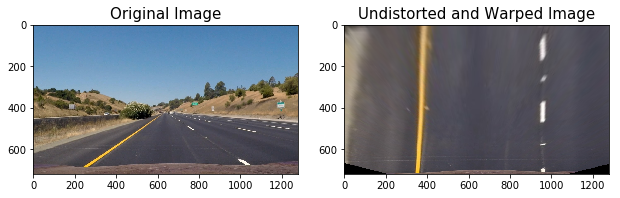

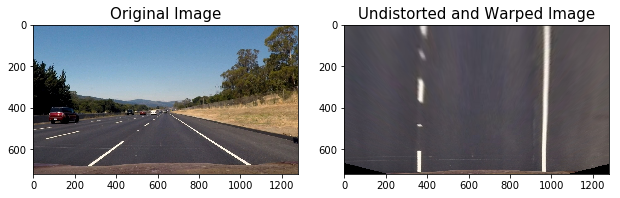

In [43]:
# Test image 1
img = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)

top_down = birdEye(img, mtx, dist,M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Test image 2
img = cv2.cvtColor(cv2.imread('test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)

top_down = birdEye(img, mtx, dist,M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Image filtering
* Color transformation
* Thresholds


## 4. Detect lines
* Detect points of left and right lines
* Count number of points, build histogram
* If min number of points is reached, fit a polynomial to those points
* Print number of detect points on video
* Convert pixel to meters
* Compute curvature of lanes

## 5. Print lines over original image
* if lines were not detected, use last known parameters 
* Smooth parameters using last frames info
* Draw lines over image
* Apply inverse transformation and show image